Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'2.0.0-beta1'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Build a lines segmentation model based on unet architecture 

Here is [the paper](https://arxiv.org/pdf/1505.04597.pdf)

In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from recognizer.datasets import Dataset
from recognizer.networks import unet
from recognizer.networks import unet_mini
from recognizer.networks import fcn
from recognizer.networks import NetworkInput

In [5]:
lines_detector_path = Dataset.processed_data_path()/"lines_detector"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

Hyperparameters

In [48]:
batch_size = 8
epochs = 16

number_of_classes = 3

In [7]:
model_save_path = Path("../recognizer/weights/lines_detector.h5")

## Load dataset

In [8]:
x = []
y = []

sorted_image_names = sorted(lines_detector_images_path.glob("*.png"))
sorted_mask_names = sorted(lines_detector_masks_path.glob("*.png"))
for image_file_name, mask_file_name in tqdm(zip(sorted_image_names, sorted_mask_names)):
    image = img_to_array(Image.open(image_file_name))
    mask = img_to_array(Image.open(mask_file_name), dtype=np.uint8) // 127
    
    x.append(image)
    y.append(mask)

x = np.array(x)
y = np.array(y)

# len(x), x[0].shape
x.shape

1539it [00:02, 672.10it/s]


(1539, 256, 256, 1)

In [9]:
x[0].dtype, y[0].dtype

(dtype('float32'), dtype('uint8'))

In [10]:
np.min(x), np.max(x)

(0.0, 255.0)

Prepare the data for training

In [11]:
np.unique(y)

array([0, 1, 2], dtype=uint8)

Normalize the data

In [12]:
# x = (x - np.mean(x)) / np.std(x)
x /= 255
y = to_categorical(y, number_of_classes)

np.min(x), np.max(x), y.shape

(0.0, 1.0, (1539, 256, 256, 3))

## Augment the data

## Build the model

In [34]:
input_shape = x[0].shape
model = unet_mini(
# model = unet(
# model = fcn(
    NetworkInput(input_shape=input_shape, number_of_classes=number_of_classes)
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 9248        dropout[0][0]                    
____________________________________________________________________________________________

## Train the model

Check progress in TensorBoard by running tensorboard --logdir=logs/lines_detector_model in terminal

In [35]:
# Try removing the old logs first
!rm -r ../logs/lines_detector_model

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_detector_model')
]

In [36]:
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
history = model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=.2,
    shuffle=True
)
history.history.keys()

Train on 1231 samples, validate on 308 samples
Epoch 1/16
1231/1231 [==============================] - 40s 32ms/sample - loss: 1.0282 - accuracy: 0.2061 - val_loss: 0.9881 - val_accuracy: 0.2058
Epoch 2/16
1231/1231 [==============================] - 34s 27ms/sample - loss: 0.8935 - accuracy: 0.1877 - val_loss: 0.7056 - val_accuracy: 0.1206
Epoch 3/16
1231/1231 [==============================] - 34s 28ms/sample - loss: 0.6512 - accuracy: 0.1014 - val_loss: 0.6135 - val_accuracy: 0.0906
Epoch 4/16
1231/1231 [==============================] - 34s 27ms/sample - loss: 0.5989 - accuracy: 0.0874 - val_loss: 0.5871 - val_accuracy: 0.0831
Epoch 5/16
1231/1231 [==============================] - 34s 28ms/sample - loss: 0.5869 - accuracy: 0.0830 - val_loss: 0.5820 - val_accuracy: 0.0832
Epoch 6/16
1231/1231 [==============================] - 34s 28ms/sample - loss: 0.5944 - accuracy: 0.0845 - val_loss: 0.5972 - val_accuracy: 0.0874
Epoch 7/16
1231/1231 [==============================] - 34s 28ms/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

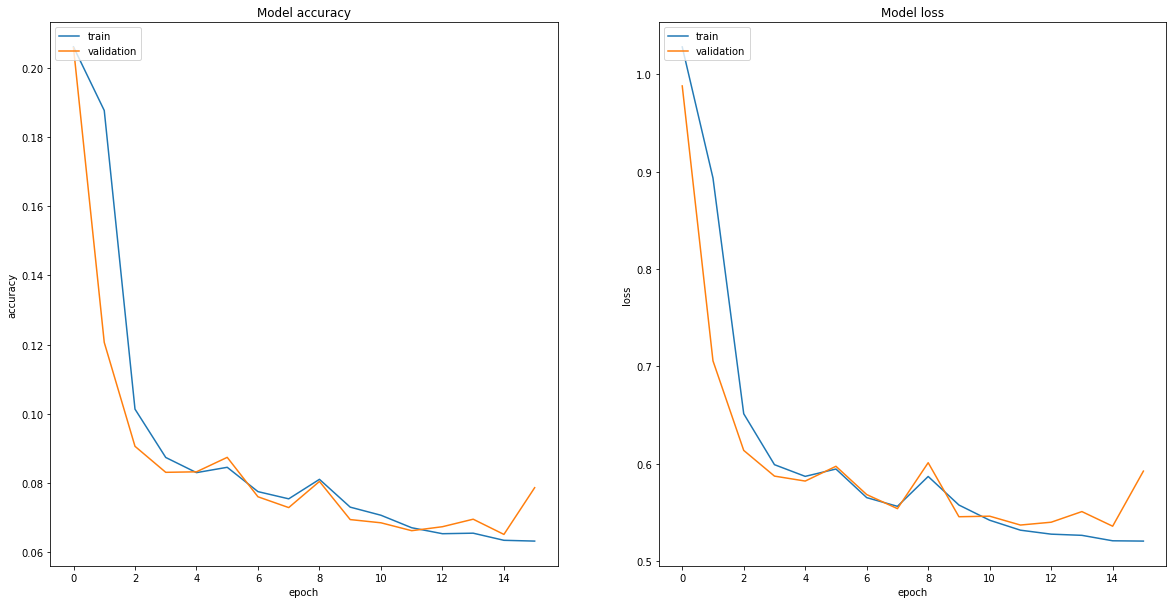

In [38]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [39]:
model.save(model_save_path)

## Restore the model

In [40]:
model = keras.models.load_model(model_save_path)

model.trainable = False
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.trainable_variables

[]

## Predict on one image

In [41]:
image_array = x[0]
test_batch = image_array.reshape((1,) + image_array.shape)

preds = model.predict(test_batch)
preds.shape

(1, 256, 256, 3)

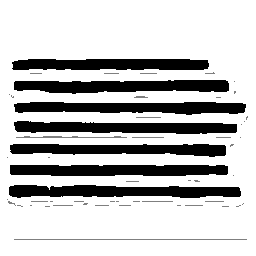

In [42]:
# Merge the 3 channel classes into one for color
pred_image_array = np.expand_dims(np.argmax(preds[0], axis=2), axis=-1)
array_to_img(pred_image_array)

In [43]:
np.min(preds[0]), np.max(preds[0])

(-61356323000.0, 2773404700.0)

In [23]:
np.min(pred_image_array), np.max(pred_image_array)

(0, 2)

In [24]:
np.argmax(preds[0], axis=1).shape

(256, 3)

In [25]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [26]:
np.expand_dims(np.argmax(preds[0], axis=2), axis=-1).shape

(256, 256, 1)

In [27]:
pred_image_array.shape

(256, 256, 1)

Check predication array

In [28]:
for row in preds[0]:
    if np.max(row) > 0:
        print(row)

[[1.00000000e+00 7.63449007e-16 1.70455110e-16]
 [1.00000000e+00 7.63449007e-16 1.70455110e-16]
 [1.00000000e+00 7.63443183e-16 1.70453800e-16]
 [1.00000000e+00 7.63446095e-16 1.70454462e-16]
 [1.00000000e+00 7.63440324e-16 1.70453800e-16]
 [1.00000000e+00 7.63446095e-16 1.70454462e-16]
 [1.00000000e+00 7.63440324e-16 1.70453152e-16]
 [9.99797404e-01 9.05802590e-05 1.11997615e-04]
 [9.99797404e-01 9.05803536e-05 1.11997615e-04]
 [9.99797404e-01 9.05803536e-05 1.11997615e-04]
 [9.99797404e-01 9.05801789e-05 1.11997397e-04]
 [9.99797404e-01 9.05802590e-05 1.11997397e-04]
 [9.99797404e-01 9.05801789e-05 1.11997295e-04]
 [9.99797404e-01 9.05802590e-05 1.11997397e-04]
 [9.99953270e-01 2.56845215e-05 2.11266852e-05]
 [9.99953270e-01 2.56845451e-05 2.11266852e-05]
 [9.99953270e-01 2.56845706e-05 2.11267252e-05]
 [9.99953270e-01 2.56845451e-05 2.11266852e-05]
 [9.99953270e-01 2.56844960e-05 2.11266633e-05]
 [9.99953270e-01 2.56845451e-05 2.11266852e-05]
 [9.99953270e-01 2.56845215e-05 2.112666

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [30]:
for row in np.argmax(preds[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")

>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 0 1 1

Check target array

In [31]:
for row in y[0]:
    if np.max(row) > 0:
        print(row)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1.

In [32]:
np.argmax(y[0], axis=2).shape

(256, 256)

In [33]:
for row in np.argmax(y[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")

>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1